<a href="https://colab.research.google.com/github/sijuswamy/intel-unnati-training/blob/main/fakenews_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size ="4">**Importing all the libraries**</font>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os
import pickle
import time
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer

<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [ ]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

--2023-06-13 05:47:58--  https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip
Resolving onlineacademiccommunity.uvic.ca (onlineacademiccommunity.uvic.ca)... 142.104.197.46
Connecting to onlineacademiccommunity.uvic.ca (onlineacademiccommunity.uvic.ca)|142.104.197.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43106824 (41M) [application/zip]
Saving to: ‘data/News-_dataset.zip’

News-_dataset.zip   100%[===================>]  41.11M   830KB/s    in 54s     

2023-06-13 05:48:54 (773 KB/s) - ‘data/News-_dataset.zip’ saved [43106824/43106824]

Archive:  data/News-_dataset.zip
  inflating: data/Fake.csv           
  inflating: data/True.csv           


<font size="4">**Read the data csv file**</font>

In [ ]:
fake_data = pd.read_csv('data/Fake.csv')
#fake_data.head()

In [ ]:
true_data = pd.read_csv('data/True.csv')
#true_data.head()

Assigning Classes to the Dataset

In [ ]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [ ]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

## User defined function for data-visualization

In [ ]:
def visualize(dataFile,feature):
    plt.figure(figsize = (6,4))
    sns.set(style = "whitegrid",font_scale = 1.0)
    chart = sns.countplot(x = feature, data = data)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
    plt.show()
    #return sns.countplot(x=feature, data=dataFile, palette='hls')

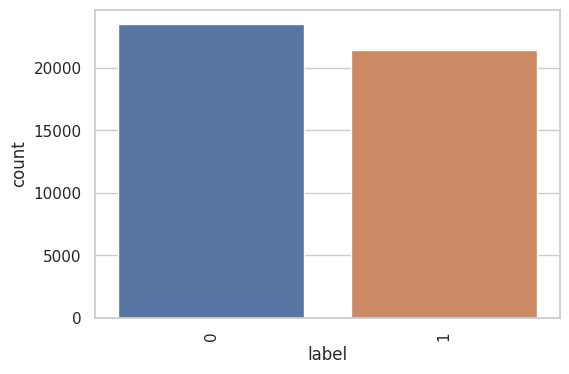

In [ ]:
visualize(data,'label')

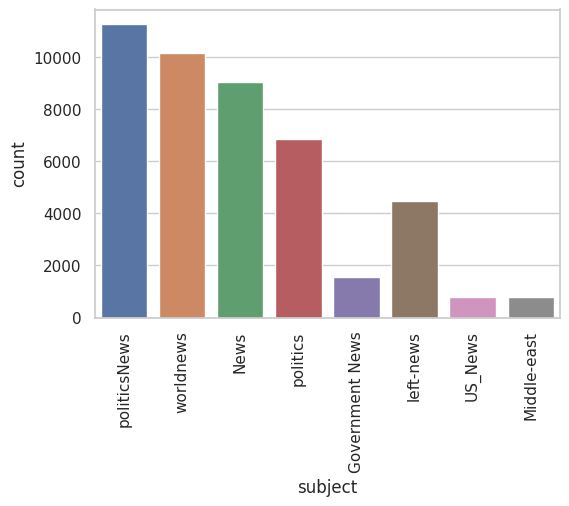

In [ ]:
visualize(data,'subject')

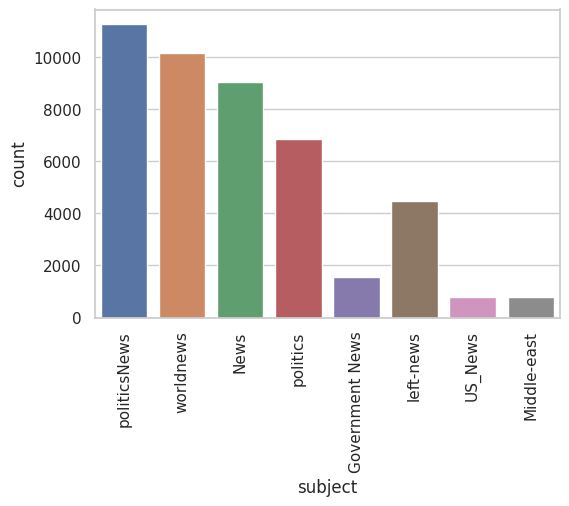

In [ ]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

<font size="4">**Data preprocessing**</font>

In [ ]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [ ]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [ ]:
pip install WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data.shape

(44898, 2)

In [ ]:
def Check_forNAN(data):

    print("Wait...Checking for NANs in the Dataset is progressing...")
    print("Total NANs:",data.isnull().sum())
    print("Checking is completed successfully...\n")
    print(10*"--","\n")
    print("Summary of the dataframe:......\n")
    data.info()

    print("check finished.")

Check if there is any null value (If so, then we will drop those rows)

In [ ]:
Check_forNAN(data)

Wait...Checking for NANs in the Dataset is progressing...
Total NANs: text     0
label    0
dtype: int64
Checking is completed successfully...

-------------------- 

Summary of the dataframe:......

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB
check finished.


 Now we have to shuffle the dataset to prevent the model to get bias

In [ ]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,"Powell rose to top of Trump's list as safe, sa...",1
1,"WATCH: Dem Senator BLASTS Trump, Calls Him A ...",0
2,Exclusive: Republicans could target Obamacare ...,1
3,"U.S., Gulf nations target Yemen terrorism fina...",1
4,"Thanks To Trump, Companies Are Pulling Out Of...",0


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

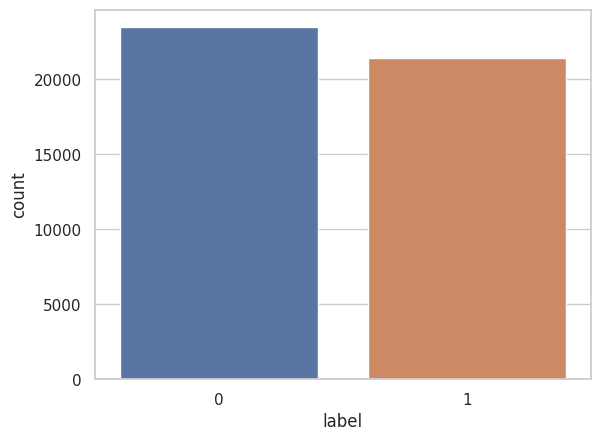

In [ ]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

## Stemming

In [ ]:
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

In [ ]:
#data['tokenized'] = data.apply(lambda x: tokenize(x['text']), axis=1)
#data.head()

In [ ]:
from nltk.corpus import stopwords

In [ ]:
def remove_stopwords(tokenized_column):
    stops = set(stopwords.words("english"))
    return [word for word in tokenized_column if not word in stops]

In [ ]:
#data['stopwords_removed'] = data.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)

In [ ]:
def apply_stemming(tokenized_column):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokenized_column]

In [ ]:
#data['stemmed'] = data.apply(lambda x: apply_stemming(x['stopwords_removed']), axis=1)
#data['stemmed'].head()

In [ ]:
def rejoin_words(tokenized_column):
    return ( " ".join(tokenized_column))

In [ ]:
#data['rejoined'] = data.apply(lambda x: rejoin_words(x['stemmed']), axis=1)
#data.head()

In [ ]:
## Creating Data cleaning and pre-processing function
def PreProcess(data):
    data['tokenized'] = data.apply(lambda x: tokenize(x['text']), axis=1)
    data['stopwords_removed'] = data.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)
    data['stemmed'] = data.apply(lambda x: apply_stemming(x['stopwords_removed']), axis=1)
    data['rejoined'] = data.apply(lambda x: rejoin_words(x['stemmed']), axis=1)

In [ ]:
# calling the preprocesss function
time_start = time.time()
PreProcess(data)
print('Preprocessing done! Time elapsed: {} seconds'.format(time.time()-time_start))

Preprocessing done! Time elapsed: 305.6430735588074 seconds


In [ ]:
chi2_features

SelectKBest(k=1000, score_func=<function chi2 at 0x7fda21f31e10>)

In [ ]:
print(X)

  (0, 965)	0.06295353001886912
  (0, 923)	0.10872208019979687
  (0, 849)	0.1648658181354425
  (0, 822)	0.11785659457838703
  (0, 793)	0.06876654338265131
  (0, 761)	0.42974571540385553
  (0, 759)	0.11242061092762386
  (0, 755)	0.2756843602054749
  (0, 738)	0.036857985391240314
  (0, 701)	0.1422615308285886
  (0, 680)	0.07577174228044051
  (0, 650)	0.08105016227689776
  (0, 611)	0.10589801633827892
  (0, 558)	0.0646214660820204
  (0, 556)	0.06687333813368254
  (0, 553)	0.430636248349066
  (0, 502)	0.16404844552102196
  (0, 465)	0.09403602709385313
  (0, 415)	0.08960544004179058
  (0, 414)	0.09377839194828672
  (0, 340)	0.09650664340054711
  (0, 329)	0.12304454590881146
  (0, 279)	0.08102668671855988
  (0, 276)	0.09479829431383857
  (0, 238)	0.2693491109140433
  :	:
  (44897, 293)	0.018261366042048213
  (44897, 289)	0.04499755066273289
  (44897, 283)	0.022440705121364164
  (44897, 282)	0.03707240258108282
  (44897, 280)	0.013980703792842237
  (44897, 231)	0.07132353546050685
  (44897, 22

## Visualization of bag of words and word count

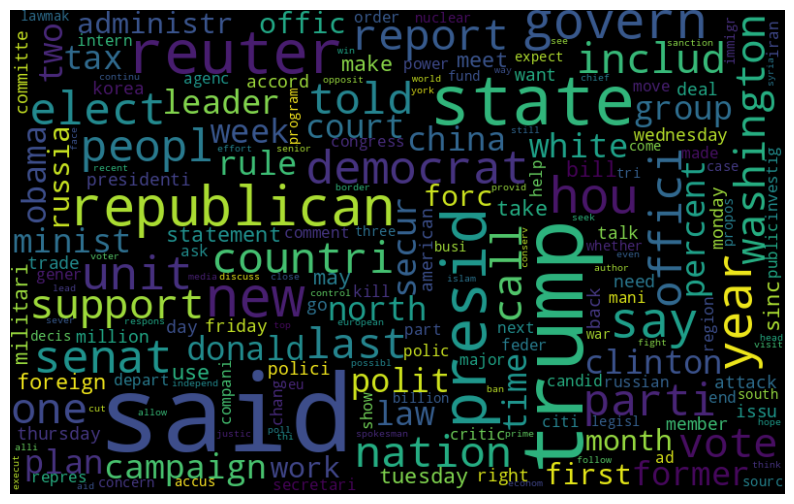

In [ ]:
from wordcloud import WordCloud
fake_data = data[data["label"] == "1"]
all_words = ' '.join([text for text in fake_data.rejoined])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

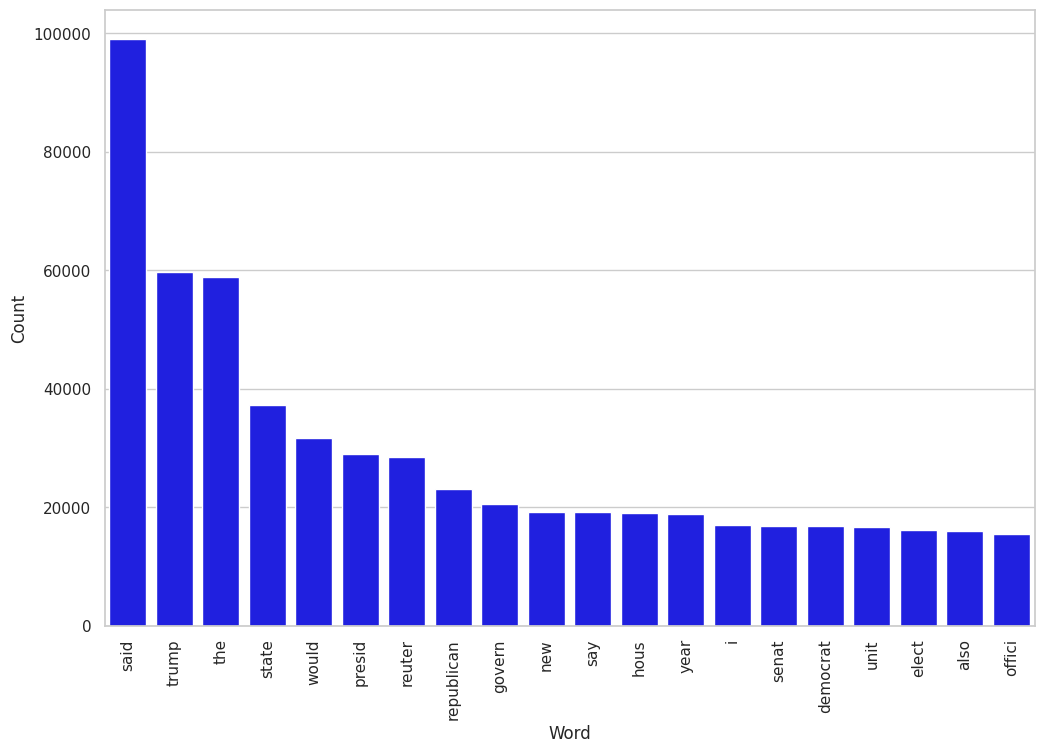

In [ ]:
# plotting word cound after pre-processing
counter(data[data['label'] == '1'], 'rejoined', 20)

## Spliting the dataframe into data and label

In [ ]:
data.label = data.label.astype(str)
#data.label = data.label.str.strip()
dict = { 'REAL' : 1 , 'FAKE' : '0'}
#data['label'] = data['label'].map(dict)
data['label'].head()

0    1
1    0
2    1
3    1
4    0
Name: label, dtype: object

In [ ]:
X = data['rejoined']
y = data['label']

## Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = CountVectorizer()


In [ ]:
time_start = time.time()
#count_vectorizer.fit_transform(X)
freq_term_matrix = count_vectorizer.fit_transform(X)
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)
print('TF-IDF matrix creation done! Time elapsed: {} seconds'.format(time.time()-time_start))
print(tf_idf_matrix)

TF-IDF matrix creation done! Time elapsed: 7.842782974243164 seconds
  (0, 74871)	0.015939748384807283
  (0, 74746)	0.016567996127254285
  (0, 74679)	0.29529764828270133
  (0, 74643)	0.009965290149278555
  (0, 74037)	0.01714750829199343
  (0, 73989)	0.014254001000001904
  (0, 73956)	0.035742878264387865
  (0, 73703)	0.030772375043120012
  (0, 73645)	0.034542435369253235
  (0, 73413)	0.024970988460947054
  (0, 73166)	0.07447578105917319
  (0, 73087)	0.01698610771204505
  (0, 73049)	0.04412214808081261
  (0, 72825)	0.01373990690322604
  (0, 72538)	0.012717866623705245
  (0, 72371)	0.08921987376515582
  (0, 72275)	0.03500231062411257
  (0, 72184)	0.019324548375443923
  (0, 71840)	0.032699141984144635
  (0, 71670)	0.02324974217807846
  (0, 71641)	0.018849584123487736
  (0, 71510)	0.034984705667339924
  (0, 71416)	0.06105102890788643
  (0, 71359)	0.02637756343186478
  (0, 70073)	0.03704669657535377
  :	:
  (44897, 6017)	0.024835567638766255
  (44897, 5627)	0.02923299305738343
  (44897, 5483

In [ ]:
tf_idf_matrix.shape

(44898, 75749)

In [ ]:
pickle.dump(tfidf,open('./tfidf_vectorizer.pkl', 'wb'))

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# N features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k = 1000)
X_small = chi2_features.fit_transform(tf_idf_matrix, y)

## Splitting data for training and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tf_idf_matrix,y, random_state=21)

In [ ]:
print(x_test[:20,:])

In [ ]:
x_train.shape

(33673, 75749)

<font size="4">**Model training, Evaluation, and Prediction**</font>

## Fake-news detection using ML

### 1. Logistic Regression

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_train

In [ ]:
#logit model
#from sklearn.linear_model import LogisticRegression
time_start = time.time()
logitmodel = LogisticRegression()
logitmodel.fit(x_train, y_train)
y_pred=logitmodel.predict(x_test)
Accuracy = logitmodel.score(x_test, y_test)
print(Accuracy*100)
print('Logit Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

98.75278396436525
Logit Model done! Time elapsed: 5.0603249073028564 seconds


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
y_pred=logitmodel.predict(x_train)
mse = mean_squared_error(y_train, y_pred)
rmse = sqrt(mse)
print("RMSE of Logit model-training:",rmse)

RMSE of Logit model-training: 0.08442376489188268


In [ ]:
y_pred=logitmodel.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of Logit model-testing:",rmse)

RMSE of Logit model-testing: 0.11404683912531997


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5901
           1       0.99      0.99      0.99      5324

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5843   74]
 [  43 5265]]


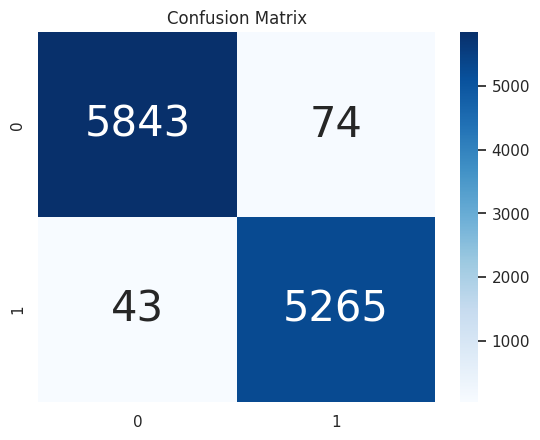

In [ ]:
# confusion matrix sns heatmap
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

### 2. Navie Bayes classification model

In [ ]:
#NB
from sklearn.naive_bayes import MultinomialNB
time_start = time.time()
NB = MultinomialNB()
NB.fit(x_train, y_train)
y_pred=NB.predict(x_test)
Accuracy = NB.score(x_test, y_test)
print(Accuracy*100)
print('NB Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

93.53229398663697
Logit Model done! Time elapsed: 0.15982961654663086 seconds


In [ ]:
import numpy as np

In [ ]:
y_pred

array(['1', '1', '1', ..., '1', '1', '0'], dtype='<U1')

In [ ]:
y_pred =y_pred.astype(np.float)

<ipython-input-55-19ffa1aeb8d1>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred =y_pred.astype(np.float)


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of NB model-testing:",rmse)

RMSE of Logit model-testing: 0.2543168498814624


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5901
           1       0.95      0.92      0.93      5324

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



In [ ]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

### 3. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
time_start = time.time()
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
Accuracy = clf.score(x_test, y_test)
print(Accuracy*100)
print('DT Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

99.5011135857461
Logit Model done! Time elapsed: 33.668766260147095 seconds


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5901
           1       1.00      0.99      0.99      5324

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
y_pred=clf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of DT model-testing:",rmse)

RMSE of DT model-testing: 0.0706318918233044


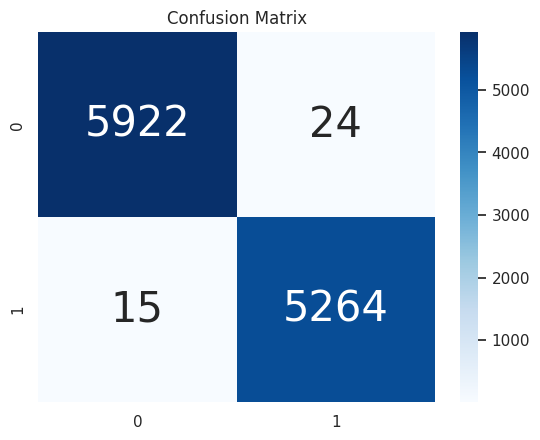

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

### 4. Passive-Aggressive Classifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
time_start = time.time()
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(x_train,y_train)
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print('PAC Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

Accuracy: 99.54%
PAC Model done! Time elapsed: 0.437838077545166 seconds


In [ ]:
#Predict on the test set and calculate accuracy
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 99.36%


In [ ]:
y_pred=y_pred.astype(np.float)

<ipython-input-65-8c853614926d>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred=y_pred.astype(np.float)


In [ ]:
#y_pred=pac.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("PAC model-testing:",rmse)

PAC model-testing: 0.06806259401305677


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5901
           1       0.99      0.99      0.99      5324

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



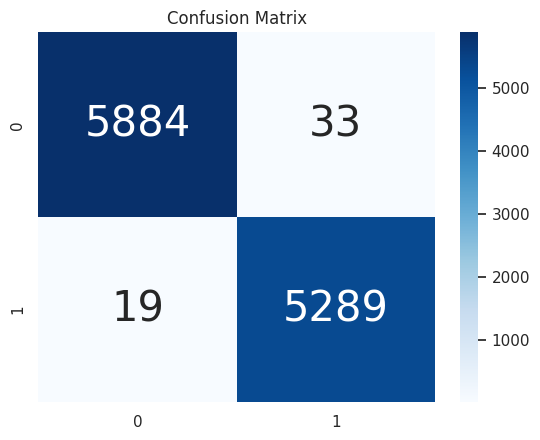

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
pickle.dump(clf,open('./selected_model.pkl', 'wb'))

In [ ]:
pickle.dump(clf,open('./selected_model.pkl', 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open('./selected_model.pkl', 'rb'))

<font size="4">**Using the saved model for fake-news prediction from a new data**</font>

In [ ]:
text=["Chat GPT is Blocked in India"]
data1=pd.DataFrame(text,columns=["text"])

In [ ]:
data1.head()

,text,tokenized,stopwords_removed,stemmed,rejoined
0,Chat GPT is Blocked in India,"[Chat, GPT, is, Blocked, in, India]","[Chat, GPT, Blocked, India]","[chat, gpt, block, india]",chat gpt block india


In [ ]:
def fake_news_detector(data1):
    PreProcess(data1)
    X1 = data1['rejoined']
    #count_vectorizer.fit_transform(X1)
    freq_term_matrix1 = count_vectorizer.fit_transform(X1)
    tf_idf_matrix1 = tfidf.transform(freq_term_matrix1)
    print(tf_idf_matrix1)
    prediction=loaded_model.predict(tf_idf_matrix1)
    if prediction[0] == 0:
        print("Prediction of the News :  Looking Fake⚠ News📰 ")
    else:
        print("Prediction of the News : Looking Real News📰 ")

In [ ]:
fake_news_detector(data1)

ValueError: ignored

## Running a small model with feature extraction

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_small,y, random_state=21)

In [ ]:
x_train.shape

(33673, 1000)

In [ ]:
x_test.shape

(11225, 1000)

In [ ]:
#logit short model
#from sklearn.linear_model import LogisticRegression
time_start = time.time()
logitmodel = LogisticRegression()
logitmodel.fit(x_train, y_train)
y_pred=logitmodel.predict(x_test)
Accuracy = logitmodel.score(x_test, y_test)
print(Accuracy*100)
print('Logit Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

98.29844097995546
Logit Model done! Time elapsed: 0.3864772319793701 seconds


In [ ]:
y_pred=logitmodel.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of Logit small model-testing:",rmse)

RMSE of Logit small model-testing: 0.13044382009296351


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5885
           1       0.98      0.99      0.98      5340

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



In [ ]:
#NB
from sklearn.naive_bayes import MultinomialNB
time_start = time.time()
NB = MultinomialNB()
NB.fit(x_train, y_train)
y_pred=NB.predict(x_test)
Accuracy = NB.score(x_test, y_test)
print(Accuracy*100)
print('NB Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

94.08463251670378
NB Model done! Time elapsed: 0.21358108520507812 seconds


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5885
           1       0.94      0.93      0.94      5340

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



In [ ]:
y_pred =y_pred.astype(np.float)

<ipython-input-78-19ffa1aeb8d1>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred =y_pred.astype(np.float)


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of NB model-testing:",rmse)

RMSE of NB model-testing: 0.2432152849492855


In [ ]:
from sklearn.tree import DecisionTreeClassifier
time_start = time.time()
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
Accuracy = clf.score(x_test, y_test)
print(Accuracy*100)
print('DT Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

99.3674832962138
DT Model done! Time elapsed: 7.4571404457092285 seconds


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5885
           1       0.99      0.99      0.99      5340

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of DT model-testing:",rmse)

RMSE of DT model-testing: 0.07953091875404128


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
time_start = time.time()
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(x_train,y_train)
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print('PAC Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

Accuracy: 99.3%
PAC Model done! Time elapsed: 0.5946242809295654 seconds


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5885
           1       0.99      1.00      0.99      5340

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
y_pred =y_pred.astype(np.float)

<ipython-input-88-19ffa1aeb8d1>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred =y_pred.astype(np.float)


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of PAC model-testing:",rmse)

RMSE of PAC model-testing: 0.08389196573789104
